# <center> ⚡ Lightning практика 🛠

В этом шаге предлагаем вам попрактиковаться в переносе кода обучения нейросети с `PyTorch` на `PyTorch Lightning`.

Вам дан ноутбук с обучением простой свёрточной нейросети, реализованной на чистом `PyTorch`, которую необходимо перенести на `PyTorch Ligthning` и обучить её с помощью `Trainer`, выполнив все условия.

Вам необходимо сдать файл с расширением любое_имя.py в котором:

**Основное задание (5 баллов):**

* Будет загрузка датасета
* Создание `LightningDataModule` (для этого потребуется создать `torch.Dataset`)
* Создание `LightningModule`
* Обучение модели с помощью `Trainer`  и сохранение её весов
* Запуск инференса модели на одном образце из теста

**Дополнительное задание (2 балла):**

* Добавьте считывание параметра `--fast_dev_run` при запуске файла на исполнение, который будет отвечать за проверочный прогон сетки на 1 эпохе (значение по умолчанию `False`).
* В случае успеха выводить в консоль сообщение: `"Тестовый прогон успешно пройден"`. Далее работа скрипта продолжается в обычном режиме.
* В случае неудачи выводить в консоль сообщение: `"Тестовый прогон завершился с ошибкой"`. После чего дальнейшая работа скрипта должна завершиться.
  
Пример команды: `python любое_имя.py --fast_dev_run True`
  
Файл должен запускаться командой `python любое_имя.py` и отрабатывать до конца без падений.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import time
import os
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data


import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Загружаем датасет Sign Language MNIST

Датасет представляет из себя 2 CSV файла - трэйн и тест сплиты. 
Каждая запись представляет из себя: 
* метку (номер буквы в алфавите)
* значения каждого из 780 пикселей изображения.
<img src="../data/amer_sign2.png" align="right" />

In [16]:
%%capture
# Для запуска в колаб
# !mkdir ../data/
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/sign_mnist_train.csv.zip
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/sign_mnist_test.csv.zip
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/amer_sign2.png
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/amer_sign3.png
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/american_sign_language.PNG

!unzip ../data/sign_mnist_train.csv.zip -d ../data/
!unzip ../data/sign_mnist_test.csv.zip -d ../data/

In [4]:
train = pd.read_csv('../data/sign_mnist_train.csv')
test = pd.read_csv('../data/sign_mnist_test.csv')

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
test.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222


## Определяем Pytorch Dataset and Dataloader:



In [7]:
class SignLanguageDataset(data.Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img =self.transform(img)
        
        return img, label
        

In [8]:
transforms4train = transforms.Compose([
        #transforms.Normalize(159, 40),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
]) 

In [9]:
train_dataset = SignLanguageDataset(train, transform=transforms4train)
test_dataset = SignLanguageDataset(test)

In [10]:
len(train_dataset), len(test_dataset)

(27455, 7172)

In [11]:
train_loader = data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

### Посмотрим как выглядит одно изображение из трэйна

In [12]:
def show_img(img, label):
    img = img.squeeze()
    img = img*40. + 159.
    imgnp = img.detach().numpy()
    plt.imshow(img, interpolation='bicubic')
    print(label)

In [13]:
trainiter = iter(train_loader)
img, label = next(trainiter)
print(img.shape)

torch.Size([200, 1, 28, 28])


tensor(2)


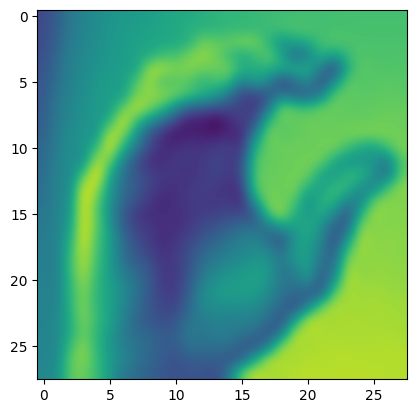

In [14]:
show_img(img[0], label[0])

In [15]:
def calc_out_size(img_size, kernel_size, stride=1, padding=1, dilation=1 ):
    out_size = ((img_size + 2 * padding - (dilation * (kernel_size - 1) + 1 )) / stride) + 1
    return int(out_size)

In [16]:
calc_out_size(28, 3)

28

## Напишем простую сверточную нейросеть и обучим её:

In [17]:
class MyConvNet(nn.Module):
    
    def __init__(self, stride=1, dilation=1, n_classes=25):
        
        super(MyConvNet, self).__init__()
        
        self.stride = stride
        self.dilation = dilation
        self.n_classes = n_classes
        
        self.block1 = nn.Sequential(
            #input=(batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(8),
            # (batch, 8, 28, 28)
            nn.AvgPool2d(2),
            # (batch, 8, 14, 14)
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(16),
            # (batch, 16, 14, 14)
            nn.AvgPool2d(2),
            # (batch, 16, 7, 7)
            nn.ReLU()
        )
        
        self.lin1 = nn.Linear(in_features=16*7*7, out_features=100)
        # (batch, 100)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(p=0.3)
        self.lin2 = nn.Linear(100, self.n_classes)
        # (batch, 25)
    
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = x.view((x.shape[0], -1))
        x = self.lin1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        
        return x

In [18]:
model = MyConvNet()
model

MyConvNet(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.3, inplace=False)
  (lin2): Linear(in_features=100, out_features=25, bias=True)
)

In [19]:
# Проверяем
sample_batch = torch.ones(20, 1, 28, 28)
print(model.block1(sample_batch).shape)
print(model.block2(model.block1(sample_batch)).shape)
print(model(sample_batch).shape)

torch.Size([20, 8, 14, 14])
torch.Size([20, 16, 7, 7])
torch.Size([20, 25])


## Напишем циклы тренировки и валидации модели:

In [22]:
def eval_model(model, criterion, test_loader, cuda=True):
    model = model.to(device)
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels in test_loader:
        batch = batch.to(device)
        labels = labels.to(device)
        
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy

In [25]:
def train_model(n_epochs, model, optimizer, criterion, train_loader, test_loader, cuda=True):
    model = model.to(device)
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels in train_loader:
            batch = batch.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
              
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_loader, cuda=True)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc        
        
        

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [27]:
model, train_loss, train_acc, test_loss, test_acc = train_model(20, model, optimizer, criterion, train_loader, test_loader, cuda=True)

EPOCH 0 (7.4631 s.): train loss - 0.010604227893054485, train accuracy - 0.38910945183026774; test loss - 0.005253372248262167, test accuracy - 0.7025934188510876
EPOCH 1 (6.3606 s.): train loss - 0.004949234426021576, train accuracy - 0.7144782371152796; test loss - 0.0026538572274148464, test accuracy - 0.8146960401561628
EPOCH 2 (6.5464 s.): train loss - 0.0033039452973753214, train accuracy - 0.8061555272263704; test loss - 0.002210389357060194, test accuracy - 0.8420245398773006
EPOCH 3 (6.4181 s.): train loss - 0.002693175571039319, train accuracy - 0.8386814787834639; test loss - 0.0018811572808772326, test accuracy - 0.8845510317902956
EPOCH 4 (6.6949 s.): train loss - 0.0022646549623459578, train accuracy - 0.8628300855946094; test loss - 0.0018512426177039742, test accuracy - 0.8789737869492471
EPOCH 5 (6.4157 s.): train loss - 0.0020836456678807735, train accuracy - 0.8703332726279366; test loss - 0.0017863120883703232, test accuracy - 0.8842721695482432
EPOCH 6 (6.4565 s.):

Text(0.5, 1.0, 'Accuracy')

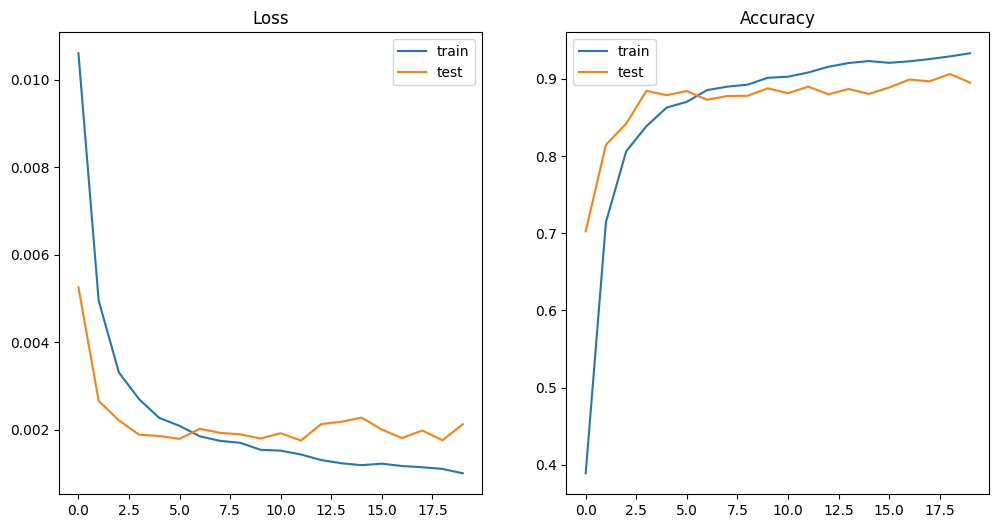

In [28]:
# Посмотрим прогресс обучения на графиках
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [29]:
# Сохраним модель
state = {'model': model.state_dict(),
        'epoch': 20}

model_path = Path('../models')
model_name = 'myconvnet_sign_lang.pth'
model_path.mkdir(parents=True, exist_ok=True) # Создаем папку, если ее не существует

torch.save(state, model_path / model_name)

## Посмотрим как модель предсказывает

In [30]:
testiter = iter(test_loader)
img, label = next(testiter)
model = model.cpu()

Fact: 0, Prediction: 0
tensor(0)


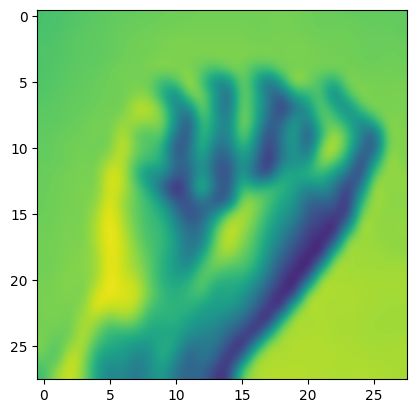

In [31]:
idx=12
pred = model(img)
print(f'Fact: {label[idx]}, Prediction: {(torch.argmax(pred[idx], dim=0))}')
show_img(img[idx], label[idx])

### Запись файла для сдачи на Stepik

In [ ]:
%%writefile example.py
#!/usr/bin/env python

# your code here

def main():
    pass # your code here

if __name__ == "__main__":
    # your code here
    main()

**Проверка работоспособности**

In [ ]:
!python example.py

In [ ]:
# Для дополнительного задания
!python example.py --fast_dev_run True